In [9]:
# importing useful libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
%matplotlib inline
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [10]:
#reading cvs files
health_camp_detail = pd.read_csv("/Health_Camp_Detail.csv")
patient_details = pd.read_csv("/Patient_Profile.csv")
f_health_camp_attend = pd.read_csv("/First_Health_Camp_Attended.csv")
s_health_camp_attend = pd.read_csv("/Second_Health_Camp_Attended.csv")
t_health_camp_attend = pd.read_csv("/Third_Health_Camp_Attended.csv")
train = pd.read_csv("/Train.csv")
test = pd.read_csv("/test.csv")

In [11]:
print(health_camp_detail.head())

   Health_Camp_ID Camp_Start_Date Camp_End_Date Category1 Category2  Category3
0            6560       16-Aug-03     20-Aug-03     First         B          2
1            6530       16-Aug-03     28-Oct-03     First         C          2
2            6544       03-Nov-03     15-Nov-03     First         F          1
3            6585       22-Nov-03     05-Dec-03     First         E          2
4            6561       30-Nov-03     18-Dec-03     First         E          1


In [12]:
#converting string date to datetime object
health_camp_detail['Camp_Start_Date']=health_camp_detail['Camp_Start_Date'].apply(lambda x:datetime.strptime(x,'%d-%b-%y'))
health_camp_detail['Camp_End_Date']=health_camp_detail['Camp_End_Date'].apply(lambda x:datetime.strptime(x,'%d-%b-%y'))

In [13]:
#adding suffix for easy identification during one-hot encoding
health_camp_detail['Category1'] = health_camp_detail['Category1'] + '_cat1'
health_camp_detail['Category2'] = health_camp_detail['Category2'] + '_cat1'
health_camp_detail['Category3'] = health_camp_detail['Category3'].apply(lambda x: str(x)+'_cat3')

In [14]:
health_camp_detail.head()

,Health_Camp_ID,Camp_Start_Date,Camp_End_Date,Category1,Category2,Category3
0,6560,2003-08-16,2003-08-20,First_cat1,B_cat1,2_cat3
1,6530,2003-08-16,2003-10-28,First_cat1,C_cat1,2_cat3
2,6544,2003-11-03,2003-11-15,First_cat1,F_cat1,1_cat3
3,6585,2003-11-22,2003-12-05,First_cat1,E_cat1,2_cat3
4,6561,2003-11-30,2003-12-18,First_cat1,E_cat1,1_cat3


In [15]:
health_camp_detail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65 entries, 0 to 64
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Health_Camp_ID   65 non-null     int64         
 1   Camp_Start_Date  65 non-null     datetime64[ns]
 2   Camp_End_Date    65 non-null     datetime64[ns]
 3   Category1        65 non-null     object        
 4   Category2        65 non-null     object        
 5   Category3        65 non-null     object        
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 3.2+ KB


In [16]:
health_camp_detail['Health_Camp_ID'].value_counts()

6560    1
6587    1
6555    1
6543    1
6537    1
       ..
6523    1
6524    1
6527    1
6554    1
6577    1
Name: Health_Camp_ID, Length: 65, dtype: int64

In [17]:
sum(health_camp_detail['Health_Camp_ID'].value_counts()>1)
# No duplicate health camps, should not cause any issue during join

0

In [18]:
health_camp_detail[health_camp_detail['Camp_End_Date']<health_camp_detail['Camp_Start_Date']]
# No instances of campaign end date < camp start date

,Health_Camp_ID,Camp_Start_Date,Camp_End_Date,Category1,Category2,Category3


### Feature Engineering

In [19]:
#Camp_Start_Date
health_camp_detail['Camp_Start_Month']=health_camp_detail['Camp_Start_Date'].apply(lambda x:x.month)
health_camp_detail['Camp_Start_Day']=health_camp_detail['Camp_Start_Date'].apply(lambda x:x.day)
health_camp_detail['Camp_Start_Quarter']=health_camp_detail['Camp_Start_Date'].apply(lambda x:x.quarter)

#Camp_End_Date
health_camp_detail['Camp_End_Month']=health_camp_detail['Camp_End_Date'].apply(lambda x:x.month)
health_camp_detail['Camp_End_Day']=health_camp_detail['Camp_End_Date'].apply(lambda x:x.day)
health_camp_detail['Camp_End_Quarter']=health_camp_detail['Camp_End_Date'].apply(lambda x:x.quarter)

#Camp_Duration
health_camp_detail['Camp_Duration']=(health_camp_detail['Camp_End_Date']-health_camp_detail['Camp_Start_Date']).astype('timedelta64[D]')

In [20]:
health_camp_detail.head(2)

,Health_Camp_ID,Camp_Start_Date,Camp_End_Date,Category1,Category2,Category3,Camp_Start_Month,Camp_Start_Day,Camp_Start_Quarter,Camp_End_Month,Camp_End_Day,Camp_End_Quarter,Camp_Duration
0,6560,2003-08-16,2003-08-20,First_cat1,B_cat1,2_cat3,8,16,3,8,20,3,4.0
1,6530,2003-08-16,2003-10-28,First_cat1,C_cat1,2_cat3,8,16,3,10,28,4,73.0


In [21]:
#Creating Dummies
#Category1
category1_dummies = pd.get_dummies(health_camp_detail['Category1'],drop_first=True)
health_camp_detail = pd.concat([health_camp_detail.drop('Category1',axis=1),category1_dummies],axis=1)

#Category2
category2_dummies = pd.get_dummies(health_camp_detail['Category2'],drop_first=True)
health_camp_detail = pd.concat([health_camp_detail.drop('Category2',axis=1),category2_dummies],axis=1)

#Category3
category3_dummies = pd.get_dummies(health_camp_detail['Category3'],drop_first=True)
health_camp_detail = pd.concat([health_camp_detail.drop('Category3',axis=1),category3_dummies],axis=1)

#Weekends
health_camp_detail['weekends_during_campaign']=[pd.date_range(x,y).weekday.isin([5,6]).sum() for x , y in zip(health_camp_detail['Camp_Start_Date'],health_camp_detail['Camp_End_Date'])]

In [22]:
health_camp_detail.head(2)

,Health_Camp_ID,Camp_Start_Date,Camp_End_Date,Camp_Start_Month,Camp_Start_Day,Camp_Start_Quarter,Camp_End_Month,Camp_End_Day,Camp_End_Quarter,Camp_Duration,Second_cat1,Third_cat1,B_cat1,C_cat1,D_cat1,E_cat1,F_cat1,G_cat1,2_cat3,weekends_during_campaign
0,6560,2003-08-16,2003-08-20,8,16,3,8,20,3,4.0,0,0,1,0,0,0,0,0,1,2
1,6530,2003-08-16,2003-10-28,8,16,3,10,28,4,73.0,0,0,0,1,0,0,0,0,1,22


### Exploratory Data Analysis

<Axes: xlabel='Camp_Start_Quarter', ylabel='count'>

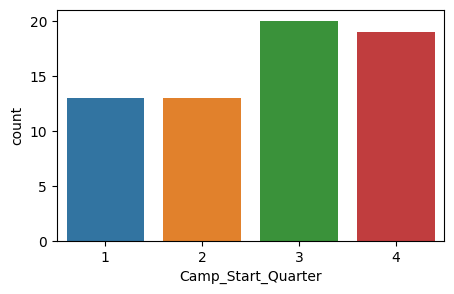

In [23]:
#camps by quarter
plt.figure(figsize=(5,3))
sns.countplot(data=health_camp_detail, x ='Camp_Start_Quarter')

<Axes: xlabel='Camp_Start_Month', ylabel='count'>

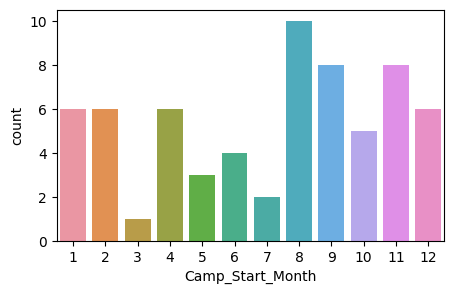

In [24]:
#camps by month
plt.figure(figsize=(5,3))
sns.countplot(data=health_camp_detail, x='Camp_Start_Month')

<Axes: >

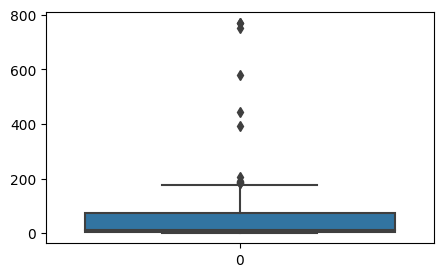

In [25]:
#camp duration distribution
plt.figure(figsize=(5,3))
sns.boxplot(health_camp_detail['Camp_Duration'])

<Axes: >

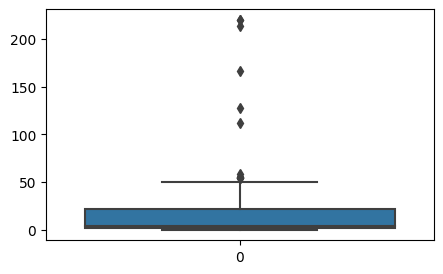

In [26]:
#camp weekends distribution
plt.figure(figsize=(5,3))
sns.boxplot(health_camp_detail['weekends_during_campaign'])

### Patient Details

In [27]:
patient_details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37633 entries, 0 to 37632
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Patient_ID         37633 non-null  int64 
 1   Online_Follower    37633 non-null  int64 
 2   LinkedIn_Shared    37633 non-null  int64 
 3   Twitter_Shared     37633 non-null  int64 
 4   Facebook_Shared    37633 non-null  int64 
 5   Income             37633 non-null  object
 6   Education_Score    37633 non-null  object
 7   Age                37633 non-null  object
 8   First_Interaction  37633 non-null  object
 9   City_Type          14249 non-null  object
 10  Employer_Category  2840 non-null   object
dtypes: int64(5), object(6)
memory usage: 3.2+ MB


In [28]:
patient_details.head(2)

,Patient_ID,Online_Follower,LinkedIn_Shared,Twitter_Shared,Facebook_Shared,Income,Education_Score,Age,First_Interaction,City_Type,Employer_Category
0,516956,0,0,0,0,1,90,39,18-Jun-03,NaN,Software Industry
1,507733,0,0,0,0,1,None,40,20-Jul-03,H,Software Industry


### Data Preprocessing

In [29]:
patient_details['First_Interaction']=patient_details['First_Interaction'].apply(lambda x:datetime.strptime(x,'%d-%b-%y'))

In [30]:
patient_details.head(1)

,Patient_ID,Online_Follower,LinkedIn_Shared,Twitter_Shared,Facebook_Shared,Income,Education_Score,Age,First_Interaction,City_Type,Employer_Category
0,516956,0,0,0,0,1,90,39,2003-06-18,NaN,Software Industry


### Feature Engineering

In [31]:
#First_Interaction_Date
patient_details['First_Interaction_Month']=patient_details['First_Interaction'].apply(lambda x:x.month)
patient_details['First_Interaction_Day']=patient_details['First_Interaction'].apply(lambda x:x.day)
patient_details['First_Interaction_Quarter']=patient_details['First_Interaction'].apply(lambda x:x.quarter)

#Making Education Score & Age as np.nan
patient_details['Education_Score']=patient_details['Education_Score'].apply(lambda x: np.nan if x=='None' else x)
patient_details['Age']=patient_details['Age'].apply(lambda x: np.nan if x=='None' else x)
patient_details['Education_Score']=pd.to_numeric(patient_details['Education_Score'], downcast="float")
patient_details['Age']=pd.to_numeric(patient_details['Age'], downcast="float")

#Consolidating Online Interactions
patient_details['Online_Interactions']=patient_details['Facebook_Shared']+patient_details['Twitter_Shared']+patient_details['LinkedIn_Shared']+patient_details['Online_Follower']

In [32]:
patient_details['Facebook_Shared'].value_counts()

0    36747
1      886
Name: Facebook_Shared, dtype: int64

In [33]:
patient_details['Online_Follower'].value_counts()

0    36785
1      848
Name: Online_Follower, dtype: int64

In [34]:
patient_details['LinkedIn_Shared'].value_counts()

0    36614
1     1019
Name: LinkedIn_Shared, dtype: int64

In [35]:
patient_details['Twitter_Shared'].value_counts()

0    36820
1      813
Name: Twitter_Shared, dtype: int64

In [36]:
patient_details['Online_Interactions'].value_counts()

0    35943
2      579
1      538
3      422
4      151
Name: Online_Interactions, dtype: int64

In [37]:
patient_details.drop(['Facebook_Shared','Twitter_Shared','LinkedIn_Shared','Online_Follower'],axis=1,inplace=True)

In [38]:
#Income
patient_details['Income']=patient_details['Income'].apply(lambda x:str(x)+'_inc')
patient_details['Income'].value_counts()

None_inc    33271
0_inc        2033
1_inc        1013
2_inc         685
3_inc         362
4_inc         156
5_inc          70
6_inc          43
Name: Income, dtype: int64

In [39]:
#City_Type
patient_details['City_Type'].value_counts()

B    2662
H    2517
A    1729
D    1704
G    1352
E    1217
C    1216
I    1036
F     816
Name: City_Type, dtype: int64

In [40]:
patient_details['City_Type']=patient_details['City_Type'].fillna('None')

In [41]:
patient_details['City_Type']=patient_details['City_Type']+'_city'

In [42]:
#Creating Dummies
#Income
income_dummies = pd.get_dummies(patient_details['Income'],drop_first=True)
patient_details = pd.concat([patient_details.drop('Income',axis=1),income_dummies],axis=1)

#City_Type
city_type_dummies = pd.get_dummies(patient_details['City_Type'],drop_first=True)
patient_details = pd.concat([patient_details.drop('City_Type',axis=1),city_type_dummies],axis=1)

### Exploratory Data Analysis

In [43]:
patient_details.head(2)

,Patient_ID,Education_Score,Age,First_Interaction,Employer_Category,First_Interaction_Month,First_Interaction_Day,First_Interaction_Quarter,Online_Interactions,1_inc,...,None_inc,B_city,C_city,D_city,E_city,F_city,G_city,H_city,I_city,None_city
0,516956,90.0,39.0,2003-06-18,Software Industry,6,18,2,0,1,...,0,0,0,0,0,0,0,0,0,1
1,507733,NaN,40.0,2003-07-20,Software Industry,7,20,3,0,1,...,0,0,0,0,0,0,0,1,0,0


In [44]:
sum(patient_details['Patient_ID'].value_counts()>1)
#No duplicates for patients

0

In [45]:
#Age
patient_details['Age'].value_counts()

41.0    361
43.0    359
42.0    336
40.0    321
39.0    299
44.0    293
45.0    240
38.0    219
72.0    218
46.0    214
73.0    199
47.0    189
37.0    186
71.0    175
74.0    172
48.0    140
49.0    127
36.0    109
50.0    102
51.0     76
70.0     71
52.0     66
35.0     66
53.0     53
75.0     43
34.0     42
54.0     40
69.0     36
55.0     35
76.0     32
56.0     25
58.0     21
77.0     18
33.0     17
57.0     16
67.0     15
68.0     14
59.0     13
60.0     10
61.0      7
32.0      7
63.0      6
65.0      6
78.0      5
64.0      4
66.0      4
62.0      3
31.0      2
30.0      2
80.0      1
Name: Age, dtype: int64

<ipython-input-46-012abce1f582>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(patient_details[(patient_details['Age']!='None')]['Age'])


<Axes: xlabel='Age', ylabel='Density'>

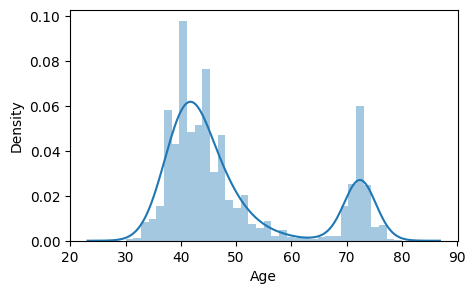

In [46]:
plt.figure(figsize=(5,3))
sns.distplot(patient_details[(patient_details['Age']!='None')]['Age'])

In [47]:
patient_details['Age'].mean(), patient_details['Age'].median()

(49.12981, 44.0)

In [48]:
#Education
patient_details['Education_Score'].value_counts()

75.000000    57
82.000000    57
79.000000    52
76.000000    51
77.000000    50
             ..
82.166664     1
80.775002     1
65.833336     1
84.735001     1
54.000000     1
Name: Education_Score, Length: 227, dtype: int64

<ipython-input-49-01b5fbc5f5de>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(patient_details[(patient_details['Education_Score']!='None')]['Education_Score'])


<Axes: xlabel='Education_Score', ylabel='Density'>

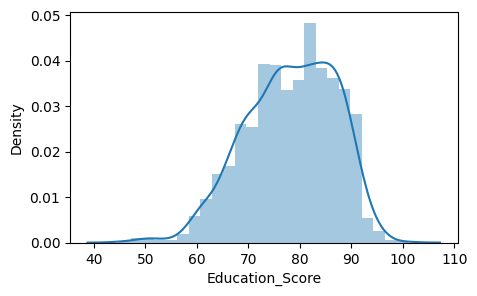

In [49]:
plt.figure(figsize=(5,3))
sns.distplot(patient_details[(patient_details['Education_Score']!='None')]['Education_Score'])

In [50]:
patient_details['Education_Score'].mean(),patient_details['Education_Score'].median()

(78.231285, 79.0)

In [51]:
patient_details['Employer_Category'].value_counts()

Technology           649
Others               477
Consulting           404
Software Industry    374
Education            188
BFSI                 167
Manufacturing        115
Retail                91
Health                88
Transport             65
Telecom               58
Real Estate           57
Food                  56
Broadcasting          51
Name: Employer_Category, dtype: int64

### Camp Details

In [52]:
f_health_camp_attend.head(2)

,Patient_ID,Health_Camp_ID,Donation,Health_Score,Unnamed: 4
0,506181,6560,40,0.439024,NaN
1,494977,6560,20,0.097561,NaN


In [53]:
f_health_camp_attend.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6218 entries, 0 to 6217
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Patient_ID      6218 non-null   int64  
 1   Health_Camp_ID  6218 non-null   int64  
 2   Donation        6218 non-null   int64  
 3   Health_Score    6218 non-null   float64
 4   Unnamed: 4      0 non-null      float64
dtypes: float64(2), int64(3)
memory usage: 243.0 KB


In [54]:
f_health_camp_attend.drop('Unnamed: 4', inplace=True, axis=1)

In [55]:
f_health_camp_attend.head(2)

,Patient_ID,Health_Camp_ID,Donation,Health_Score
0,506181,6560,40,0.439024
1,494977,6560,20,0.097561


In [56]:
s_health_camp_attend.head(2)

,Patient_ID,Health_Camp_ID,Health Score
0,526631,6536,0.875136
1,509122,6536,0.755700


In [57]:
s_health_camp_attend.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7819 entries, 0 to 7818
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Patient_ID      7819 non-null   int64  
 1   Health_Camp_ID  7819 non-null   int64  
 2   Health Score    7819 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 183.4 KB


In [58]:
t_health_camp_attend.head(2)

,Patient_ID,Health_Camp_ID,Number_of_stall_visited,Last_Stall_Visited_Number
0,517875,6527,3,1
1,504692,6578,1,1


In [59]:
t_health_camp_attend.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6515 entries, 0 to 6514
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   Patient_ID                 6515 non-null   int64
 1   Health_Camp_ID             6515 non-null   int64
 2   Number_of_stall_visited    6515 non-null   int64
 3   Last_Stall_Visited_Number  6515 non-null   int64
dtypes: int64(4)
memory usage: 203.7 KB


### Train & Test

In [60]:
train.head()

,Patient_ID,Health_Camp_ID,Registration_Date,Var1,Var2,Var3,Var4,Var5
0,489652,6578,10-Sep-05,4,0,0,0,2
1,507246,6578,18-Aug-05,45,5,0,0,7
2,523729,6534,29-Apr-06,0,0,0,0,0
3,524931,6535,07-Feb-04,0,0,0,0,0
4,521364,6529,28-Feb-06,15,1,0,0,7


In [61]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75278 entries, 0 to 75277
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Patient_ID         75278 non-null  int64 
 1   Health_Camp_ID     75278 non-null  int64 
 2   Registration_Date  74944 non-null  object
 3   Var1               75278 non-null  int64 
 4   Var2               75278 non-null  int64 
 5   Var3               75278 non-null  int64 
 6   Var4               75278 non-null  int64 
 7   Var5               75278 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 4.6+ MB


In [62]:
#dropping 334 records with not registration date
train=train.dropna()

In [63]:
train.isnull().sum()

Patient_ID           0
Health_Camp_ID       0
Registration_Date    0
Var1                 0
Var2                 0
Var3                 0
Var4                 0
Var5                 0
dtype: int64

In [64]:
test.head(2)

,Patient_ID,Health_Camp_ID,Registration_Date,Var1,Var2,Var3,Var4,Var5
0,505701,6548,21-May-06,1,0,0,0,2
1,500633,6584,02-Jun-06,0,0,0,0,0


In [65]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35249 entries, 0 to 35248
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Patient_ID         35249 non-null  int64 
 1   Health_Camp_ID     35249 non-null  int64 
 2   Registration_Date  35249 non-null  object
 3   Var1               35249 non-null  int64 
 4   Var2               35249 non-null  int64 
 5   Var3               35249 non-null  int64 
 6   Var4               35249 non-null  int64 
 7   Var5               35249 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 2.2+ MB


In [66]:
#converting string date to datetime object
train['Registration_Date']=train['Registration_Date'].apply(lambda x:datetime.strptime(x,'%d-%b-%y'))
test['Registration_Date']=test['Registration_Date'].apply(lambda x:datetime.strptime(x,'%d-%b-%y'))

train['Registration_Quarter']=train['Registration_Date'].apply(lambda x:x.quarter)
test['Registration_Quarter']=test['Registration_Date'].apply(lambda x:x.quarter)

train['Registration_Month']=train['Registration_Date'].apply(lambda x:x.month)
test['Registration_Month']=test['Registration_Date'].apply(lambda x:x.month)

train['Registration_Day']=train['Registration_Date'].apply(lambda x:x.day)
test['Registration_Day']=test['Registration_Date'].apply(lambda x:x.day)

### Merging with health and patient details, creating outcome variable

In [67]:
#merging health camp details
train=pd.merge(train,health_camp_detail,how='left')
test=pd.merge(test,health_camp_detail,how='left')

#merging patient details
train=pd.merge(train,patient_details,how='left')
test=pd.merge(test,patient_details,how='left')

#merging fhc details
train = pd.merge(train, f_health_camp_attend,  how='left', left_on=['Patient_ID','Health_Camp_ID'], right_on = ['Patient_ID','Health_Camp_ID'])

#merging shc details
train = pd.merge(train, s_health_camp_attend,  how='left', left_on=['Patient_ID','Health_Camp_ID'], right_on = ['Patient_ID','Health_Camp_ID'])

#merging thc details
train = pd.merge(train, t_health_camp_attend,  how='left', left_on=['Patient_ID','Health_Camp_ID'], right_on = ['Patient_ID','Health_Camp_ID'])

#creating outcome value
#creating binary column for first health camp
train['fhc_outcome']=train['Health_Score'].apply(lambda x: 1 if x>0 else 0 )

#creating binary column for second health camp
train['shc_outcome']=train['Health Score'].apply(lambda x: 1 if x>0 else 0 )

#creating binary column for third health camp
train['thc_outcome']=train['Number_of_stall_visited'].apply(lambda x: 1 if x>0 else 0 )

#overall outcome
train['overall_outcome']=train['fhc_outcome']+train['shc_outcome']+train['thc_outcome']

train.drop(['fhc_outcome','shc_outcome','thc_outcome','Health_Score','Health Score','Donation','Number_of_stall_visited','Last_Stall_Visited_Number'],axis=1,inplace=True)
train['overall_outcome'].value_counts()

0    54606
1    20338
Name: overall_outcome, dtype: int64

### Exploring Train Data & Feature Engineering for Train

In [68]:
train.head(2)

,Patient_ID,Health_Camp_ID,Registration_Date,Var1,Var2,Var3,Var4,Var5,Registration_Quarter,Registration_Month,...,B_city,C_city,D_city,E_city,F_city,G_city,H_city,I_city,None_city,overall_outcome
0,489652,6578,2005-09-10,4,0,0,0,2,3,9,...,0,0,0,0,0,0,0,0,1,1
1,507246,6578,2005-08-18,45,5,0,0,7,3,8,...,0,1,0,0,0,0,0,0,0,0


In [69]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74944 entries, 0 to 74943
Data columns (total 55 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Patient_ID                 74944 non-null  int64         
 1   Health_Camp_ID             74944 non-null  int64         
 2   Registration_Date          74944 non-null  datetime64[ns]
 3   Var1                       74944 non-null  int64         
 4   Var2                       74944 non-null  int64         
 5   Var3                       74944 non-null  int64         
 6   Var4                       74944 non-null  int64         
 7   Var5                       74944 non-null  int64         
 8   Registration_Quarter       74944 non-null  int64         
 9   Registration_Month         74944 non-null  int64         
 10  Registration_Day           74944 non-null  int64         
 11  Camp_Start_Date            74944 non-null  datetime64[ns]
 12  Camp

In [70]:
train.isnull().sum()

Patient_ID                       0
Health_Camp_ID                   0
Registration_Date                0
Var1                             0
Var2                             0
Var3                             0
Var4                             0
Var5                             0
Registration_Quarter             0
Registration_Month               0
Registration_Day                 0
Camp_Start_Date                  0
Camp_End_Date                    0
Camp_Start_Month                 0
Camp_Start_Day                   0
Camp_Start_Quarter               0
Camp_End_Month                   0
Camp_End_Day                     0
Camp_End_Quarter                 0
Camp_Duration                    0
Second_cat1                      0
Third_cat1                       0
B_cat1                           0
C_cat1                           0
D_cat1                           0
E_cat1                           0
F_cat1                           0
G_cat1                           0
2_cat3              

In [71]:
test.isnull().sum()

Patient_ID                       0
Health_Camp_ID                   0
Registration_Date                0
Var1                             0
Var2                             0
Var3                             0
Var4                             0
Var5                             0
Registration_Quarter             0
Registration_Month               0
Registration_Day                 0
Camp_Start_Date                  0
Camp_End_Date                    0
Camp_Start_Month                 0
Camp_Start_Day                   0
Camp_Start_Quarter               0
Camp_End_Month                   0
Camp_End_Day                     0
Camp_End_Quarter                 0
Camp_Duration                    0
Second_cat1                      0
Third_cat1                       0
B_cat1                           0
C_cat1                           0
D_cat1                           0
E_cat1                           0
F_cat1                           0
G_cat1                           0
2_cat3              

In [72]:
train_avg_edu=train['Education_Score'].mean()
train_avg_age=train['Age'].mean()
train['Education_Score']=train['Education_Score'].fillna(train_avg_edu)
train['Age']=train['Age'].fillna(train_avg_age)

train.isnull().sum()

Patient_ID                       0
Health_Camp_ID                   0
Registration_Date                0
Var1                             0
Var2                             0
Var3                             0
Var4                             0
Var5                             0
Registration_Quarter             0
Registration_Month               0
Registration_Day                 0
Camp_Start_Date                  0
Camp_End_Date                    0
Camp_Start_Month                 0
Camp_Start_Day                   0
Camp_Start_Quarter               0
Camp_End_Month                   0
Camp_End_Day                     0
Camp_End_Quarter                 0
Camp_Duration                    0
Second_cat1                      0
Third_cat1                       0
B_cat1                           0
C_cat1                           0
D_cat1                           0
E_cat1                           0
F_cat1                           0
G_cat1                           0
2_cat3              

In [73]:
test_avg_edu=test['Education_Score'].mean()
test_avg_age=test['Age'].mean()
test['Education_Score']=test['Education_Score'].fillna(test_avg_edu)
test['Age']=test['Age'].fillna(test_avg_age)

test.isnull().sum()

Patient_ID                       0
Health_Camp_ID                   0
Registration_Date                0
Var1                             0
Var2                             0
Var3                             0
Var4                             0
Var5                             0
Registration_Quarter             0
Registration_Month               0
Registration_Day                 0
Camp_Start_Date                  0
Camp_End_Date                    0
Camp_Start_Month                 0
Camp_Start_Day                   0
Camp_Start_Quarter               0
Camp_End_Month                   0
Camp_End_Day                     0
Camp_End_Quarter                 0
Camp_Duration                    0
Second_cat1                      0
Third_cat1                       0
B_cat1                           0
C_cat1                           0
D_cat1                           0
E_cat1                           0
F_cat1                           0
G_cat1                           0
2_cat3              

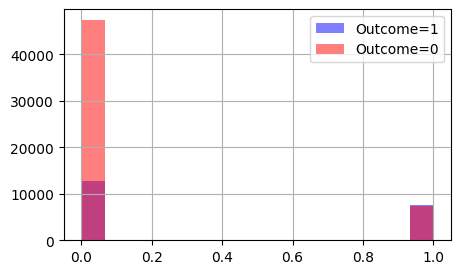

In [74]:
#Replace column as needed to visualize
plt.figure(figsize=(5,3))
train[train['overall_outcome']==1]['Second_cat1'].hist(alpha=0.5,color='blue', bins=15,label='Outcome=1')
train[train['overall_outcome']==0]['Second_cat1'].hist(alpha=0.5,color='red', bins=15,label='Outcome=0')
plt.legend()

<Axes: xlabel='Age', ylabel='Education_Score'>

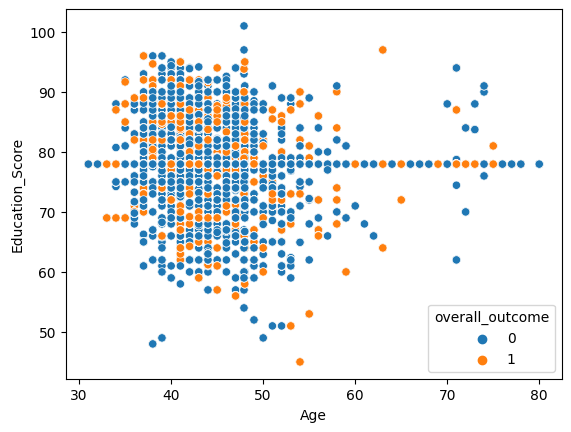

In [75]:
sns.scatterplot(x='Age',y='Education_Score',data=train,hue='overall_outcome')

### Some Additional Feature Engineering & Exploratory Data Analysis

In [76]:
#Camp_Start_Date, Camp_End_Date, Registration_Date, First_Interaction
train['regis_cs']=(train['Camp_Start_Date']-train['Registration_Date']).astype('timedelta64[D]')
train['regis_ce']=(train['Camp_End_Date']-train['Registration_Date']).astype('timedelta64[D]')
train['regis_fi']=(train['Registration_Date']-train['First_Interaction']).astype('timedelta64[D]')

test['regis_cs']=(test['Camp_Start_Date']-test['Registration_Date']).astype('timedelta64[D]')
test['regis_ce']=(test['Camp_End_Date']-test['Registration_Date']).astype('timedelta64[D]')
test['regis_fi']=(test['Registration_Date']-test['First_Interaction']).astype('timedelta64[D]')

train['fi_cs']=(train['Camp_Start_Date']-train['First_Interaction']).astype('timedelta64[D]')
train['fi_ce']=(train['Camp_End_Date']-train['First_Interaction']).astype('timedelta64[D]')

test['fi_cs']=(test['Camp_Start_Date']-test['First_Interaction']).astype('timedelta64[D]')
test['fi_ce']=(test['Camp_End_Date']-test['First_Interaction']).astype('timedelta64[D]')

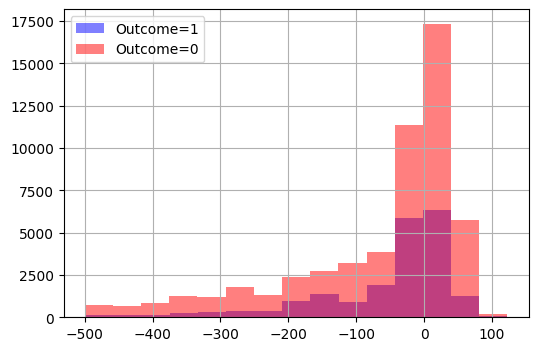

In [77]:
#regis_cs
plt.figure(figsize=(6,4))
train[train['overall_outcome']==1]['regis_cs'].hist(alpha=0.5,color='blue',
                                              bins=15,label='Outcome=1')
train[train['overall_outcome']==0]['regis_cs'].hist(alpha=0.5,color='red',
                                              bins=15,label='Outcome=0')
plt.legend()

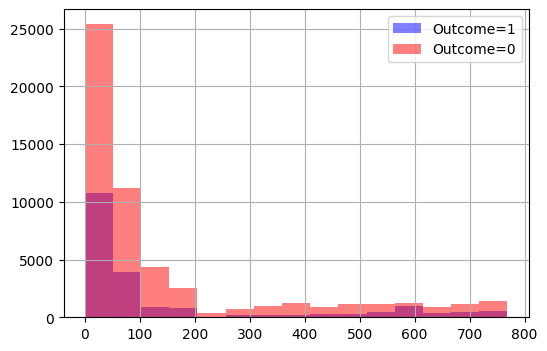

In [78]:
#regis_ce
plt.figure(figsize=(6,4))
train[train['overall_outcome']==1]['regis_ce'].hist(alpha=0.5,color='blue',
                                              bins=15,label='Outcome=1')
train[train['overall_outcome']==0]['regis_ce'].hist(alpha=0.5,color='red',
                                              bins=15,label='Outcome=0')
plt.legend()

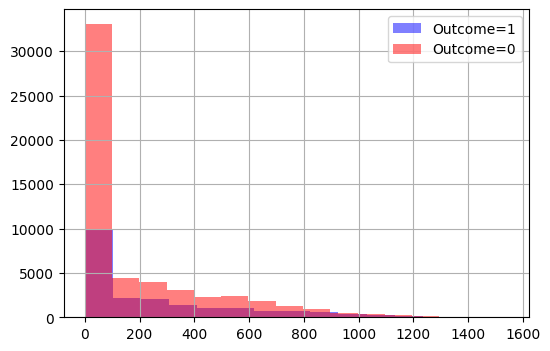

In [79]:
#regis_fi
plt.figure(figsize=(6,4))
train[train['overall_outcome']==1]['regis_fi'].hist(alpha=0.5,color='blue',
                                              bins=15,label='Outcome=1')
train[train['overall_outcome']==0]['regis_fi'].hist(alpha=0.5,color='red',
                                              bins=15,label='Outcome=0')
plt.legend()

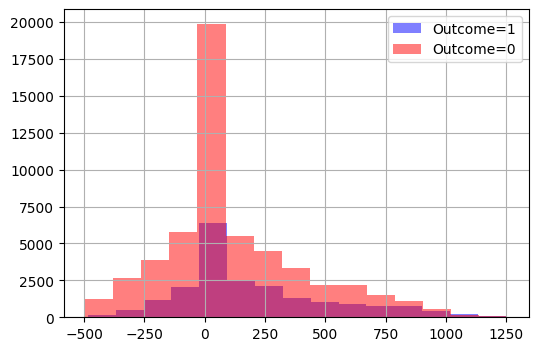

In [80]:
#fi_cs
plt.figure(figsize=(6,4))
train[train['overall_outcome']==1]['fi_cs'].hist(alpha=0.5,color='blue',
                                              bins=15,label='Outcome=1')
train[train['overall_outcome']==0]['fi_cs'].hist(alpha=0.5,color='red',
                                              bins=15,label='Outcome=0')
plt.legend()

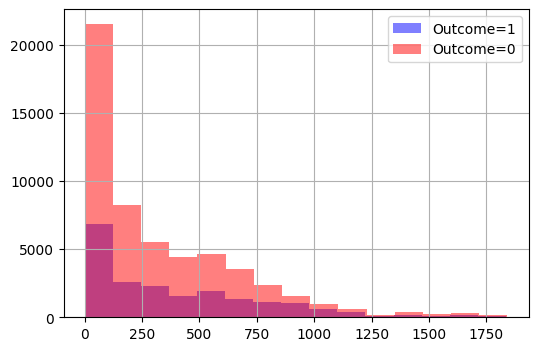

In [81]:
#fi_ce
plt.figure(figsize=(6,4))
train[train['overall_outcome']==1]['fi_ce'].hist(alpha=0.5,color='blue',
                                              bins=15,label='Outcome=1')
train[train['overall_outcome']==0]['fi_ce'].hist(alpha=0.5,color='red',
                                              bins=15,label='Outcome=0')
plt.legend()

In [82]:
train['nos_hc_per_patient']=train.groupby('Patient_ID')['Health_Camp_ID'].transform('nunique')
train['nos_pat_per_health']=train.groupby('Health_Camp_ID')['Patient_ID'].transform('nunique')

test['nos_hc_per_patient']=test.groupby('Patient_ID')['Health_Camp_ID'].transform('nunique')
test['nos_pat_per_health']=test.groupby('Health_Camp_ID')['Patient_ID'].transform('nunique')

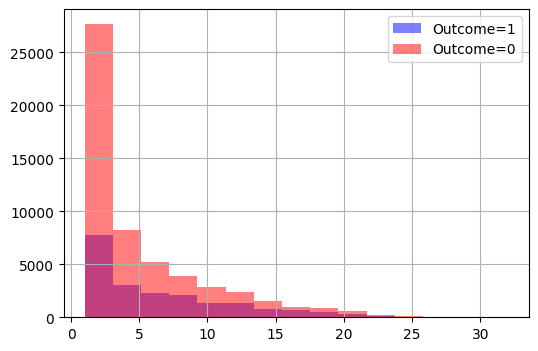

In [83]:
#nos_hc_per_patient
plt.figure(figsize=(6,4))
train[train['overall_outcome']==1]['nos_hc_per_patient'].hist(alpha=0.5,color='blue',
                                              bins=15,label='Outcome=1')
train[train['overall_outcome']==0]['nos_hc_per_patient'].hist(alpha=0.5,color='red',
                                              bins=15,label='Outcome=0')
plt.legend()

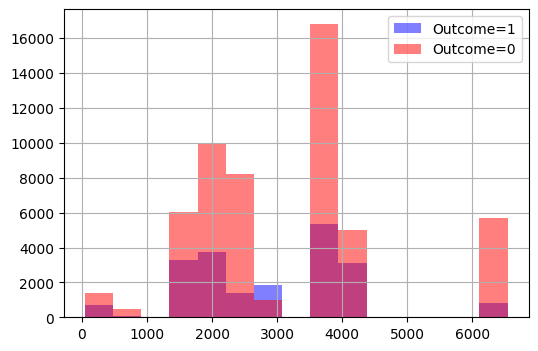

In [84]:
#nos_pat_per_health
plt.figure(figsize=(6,4))
train[train['overall_outcome']==1]['nos_pat_per_health'].hist(alpha=0.5,color='blue',
                                              bins=15,label='Outcome=1')
train[train['overall_outcome']==0]['nos_pat_per_health'].hist(alpha=0.5,color='red',
                                              bins=15,label='Outcome=0')
plt.legend()

In [85]:
corr_train=train.drop(['Registration_Date','Camp_Start_Date','Camp_End_Date','Patient_ID','Health_Camp_ID','First_Interaction','Employer_Category'],axis=1).corr()
corr_train.reset_index(inplace=True)
corr_train=corr_train[['index','overall_outcome']]
corr_train['overall_outcome']=corr_train['overall_outcome'].apply(lambda x:abs(x))
corr_train.sort_values(by='overall_outcome',ascending=False,inplace=True)

In [86]:
independent_variables=corr_train.iloc[1:len(corr_train)//2]['index'] #taking 50% of variables
independent_variables

22                       G_cat1
16                   Third_cat1
15                  Second_cat1
21                       F_cat1
20                       E_cat1
19                       D_cat1
12                 Camp_End_Day
53           nos_hc_per_patient
46                    None_city
51                        fi_cs
50                     regis_fi
37                     None_inc
13             Camp_End_Quarter
5          Registration_Quarter
52                        fi_ce
11               Camp_End_Month
6            Registration_Month
54           nos_pat_per_health
4                          Var5
30          Online_Interactions
10           Camp_Start_Quarter
29    First_Interaction_Quarter
17                       B_cat1
8              Camp_Start_Month
0                          Var1
48                     regis_cs
Name: index, dtype: object

### Checking for multicollinearity

Multicollinearity exists whenever an independent variable is highly correlated with one or more of the other independent variables in a multiple regression equation. Multicollinearity is a problem because it undermines the statistical significance of an independent variable.

In [87]:
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = [independent_variables.iloc[i] for i in range(len(independent_variables))]
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [88]:
calc_vif(train[independent_variables].dropna())

/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,variables,VIF
0,G_cat1,inf
1,Third_cat1,inf
2,Second_cat1,6.429318
3,F_cat1,10.357439
4,E_cat1,12.984236
5,D_cat1,1.572269
6,Camp_End_Day,5.853848
7,nos_hc_per_patient,4.011204
8,None_city,2.522451
9,fi_cs,inf


### Model Building 1- Neural Networks

In [100]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
!pip install tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_auc_score

In [101]:
X = train[independent_variables]
y = train['overall_outcome']

In [102]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74944 entries, 0 to 74943
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   G_cat1                     74944 non-null  uint8  
 1   Third_cat1                 74944 non-null  uint8  
 2   Second_cat1                74944 non-null  uint8  
 3   F_cat1                     74944 non-null  uint8  
 4   E_cat1                     74944 non-null  uint8  
 5   D_cat1                     74944 non-null  uint8  
 6   Camp_End_Day               74944 non-null  int64  
 7   nos_hc_per_patient         74944 non-null  int64  
 8   None_city                  74944 non-null  uint8  
 9   fi_cs                      74944 non-null  float64
 10  regis_fi                   74944 non-null  float64
 11  None_inc                   74944 non-null  uint8  
 12  Camp_End_Quarter           74944 non-null  int64  
 13  Registration_Quarter       74944 non-null  int

In [103]:
#took a help from
#https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw

model = Sequential()

#input layer
model.add(Dense(26, activation = 'relu'))
model.add(Dropout(0.5))

#hidden layer
model.add(Dense(13, activation= 'relu'))
model.add(Dropout(0.5))

#output layer
model.add(Dense(units=1, activation='sigmoid'))

#Compile model
model.compile(loss='binary_crossentropy', optimizer='adam')

In [104]:
early_stop = EarlyStopping(monitor= 'val_loss', mode='min', verbose = 1, patience=10)

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
model.fit(x=X_train,
          y=y_train,
          epochs=500,
          batch_size=256,
          validation_data=(X_test, y_test),
          callbacks=[early_stop],
          verbose=1
          )

Epoch 1/500
205/205 [==============================] - 4s 7ms/step - loss: 0.6074 - val_loss: 0.4742
Epoch 2/500
205/205 [==============================] - 1s 5ms/step - loss: 0.5138 - val_loss: 0.4512
Epoch 3/500
205/205 [==============================] - 1s 5ms/step - loss: 0.4936 - val_loss: 0.4480
Epoch 4/500
205/205 [==============================] - 1s 6ms/step - loss: 0.4857 - val_loss: 0.4429
Epoch 5/500
205/205 [==============================] - 1s 6ms/step - loss: 0.4788 - val_loss: 0.4410
Epoch 6/500
205/205 [==============================] - 1s 5ms/step - loss: 0.4753 - val_loss: 0.4365
Epoch 7/500
205/205 [==============================] - 1s 4ms/step - loss: 0.4733 - val_loss: 0.4364
Epoch 8/500
205/205 [==============================] - 1s 6ms/step - loss: 0.4689 - val_loss: 0.4340
Epoch 9/500
205/205 [==============================] - 1s 6ms/step - loss: 0.4683 - val_loss: 0.4348
Epoch 10/500
205/205 [==============================] - 1s 7ms/step - loss: 0.4652 - val_lo

Model Accuracy Checks

<Axes: >

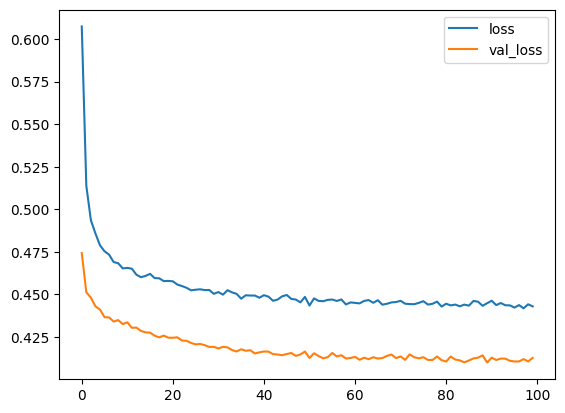

In [106]:
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()

Creating Blended Model

In [111]:
preds = 0
for seed_val in [1,3,10,15,20,33,333,1997,2020,2021]:
    print (seed_val)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=seed_val)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    model.fit(x=X_train,
              y=y_train,
              epochs=500,
              batch_size=256,
              validation_data=(X_test, y_test),
              callbacks=[early_stop],
              verbose=1
              )
    test_scaled=scaler.transform(test[independent_variables])
    predictions = model.predict_proba(test_scaled)
    preds += predictions
preds = preds/10

1
Epoch 1/500
205/205 [==============================] - 1s 5ms/step - loss: 0.4415 - val_loss: 0.4155
Epoch 2/500
205/205 [==============================] - 1s 6ms/step - loss: 0.4394 - val_loss: 0.4158
Epoch 3/500
205/205 [==============================] - 1s 5ms/step - loss: 0.4390 - val_loss: 0.4177
Epoch 4/500
205/205 [==============================] - 1s 4ms/step - loss: 0.4402 - val_loss: 0.4167
Epoch 5/500
205/205 [==============================] - 1s 4ms/step - loss: 0.4404 - val_loss: 0.4185
Epoch 6/500
205/205 [==============================] - 1s 3ms/step - loss: 0.4410 - val_loss: 0.4172
Epoch 7/500
205/205 [==============================] - 1s 2ms/step - loss: 0.4389 - val_loss: 0.4166
Epoch 8/500
205/205 [==============================] - 1s 3ms/step - loss: 0.4415 - val_loss: 0.4180
Epoch 9/500
205/205 [==============================] - 1s 3ms/step - loss: 0.4389 - val_loss: 0.4175
Epoch 10/500
205/205 [==============================] - 1s 3ms/step - loss: 0.4405 - val_

AttributeError: ignored

In [112]:
sub = pd.DataFrame({"Patient_ID":test.Patient_ID.values})
sub["Health_Camp_ID"] = test.Health_Camp_ID.values
sub["Outcome"] =  preds
sub.to_csv("nn_blended.csv", index=False)

Model Building 2 - Random Forest Classifier

In [117]:
import lightgbm as lgb
from lightgbm import LGBMClassifier

In [118]:
tr=train[train['Camp_Start_Date'] <'2005-11-01']
val=train[train['Camp_Start_Date'] >'2005-10-30']

In [123]:
params = {'verbose':1}
clf = LGBMClassifier(n_estimators=450,
                     learning_rate=0.03,
                     random_state=1,
                     colsample_bytree=0.5,
                     reg_alpha=2,
                     reg_lambda=2)
clf.fit(tr[independent_variables], tr['overall_outcome'], eval_set=[(val[independent_variables], val['overall_outcome'])],
        eval_metric = 'auc')

[LightGBM] [Info] Number of positive: 16509, number of negative: 51322
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020324 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1297
[LightGBM] [Info] Number of data points in the train set: 67831, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.243384 -> initscore=-1.134214
[LightGBM] [Info] Start training from score -1.134214


LGBMClassifier(colsample_bytree=0.5, learning_rate=0.03, n_estimators=450,
               random_state=1, reg_alpha=2, reg_lambda=2)

Creating Blended Model

In [124]:
preds = 0
for seed_val in [1,3,10,15,20,33,333,1997,2020,2021]:
    print (seed_val)
    m=LGBMClassifier(n_estimators=450,learning_rate=0.03,random_state=seed_val,colsample_bytree=0.5,reg_alpha=2,reg_lambda=2)
    m.fit(train[independent_variables],train['overall_outcome'])
    predict=m.predict_proba(test[independent_variables])[:,1]
    preds += predict
preds = preds/10

1
[LightGBM] [Info] Number of positive: 20338, number of negative: 54606
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020313 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 74944, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.271376 -> initscore=-0.987653
[LightGBM] [Info] Start training from score -0.987653
3
[LightGBM] [Info] Number of positive: 20338, number of negative: 54606
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008890 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 74944, number of used features: 26
[LightGB

In [125]:
sub = pd.DataFrame({"Patient_ID":test.Patient_ID.values})
sub["Health_Camp_ID"] = test.Health_Camp_ID.values
sub["Outcome"] =  preds
sub.to_csv("lgbm_blending1.csv", index=False)

Featuring Engineering - getting aggregate, got from top solutions

In [126]:
train.sort_values(by=['Patient_ID','Registration_Date'],inplace=True)
train['days_since_last_registration'] = train.groupby('Patient_ID')['Registration_Date'].diff().apply(lambda x: x.days)
train['days_since_next_registration'] = train.groupby('Patient_ID')['Registration_Date'].diff(-1) * (-1) / np.timedelta64(1, 'D')

test.sort_values(by=['Patient_ID','Registration_Date'],inplace=True)
test['days_since_last_registration'] = test.groupby('Patient_ID')['Registration_Date'].diff().apply(lambda x: x.days)
test['days_since_next_registration'] = test.groupby('Patient_ID')['Registration_Date'].diff(-1) * (-1) / np.timedelta64(1, 'D')

In [127]:
def agg_numeric(df, parent_var, df_name):

  # Only want the numeric variables
    parent_ids = df[parent_var].copy()
    numeric_df = df.select_dtypes('number').drop(columns={'Patient_ID', 'Health_Camp_ID','Second_cat1', 'Third_cat1', 'B_cat2', 'C_cat2', 'D_cat2', 'E_cat2',
       'F_cat2', 'G_cat2', '2_cat3','1_inc', '2_inc', '3_inc', '4_inc', '5_inc',
       '6_inc', 'None_inc', 'B_city', 'C_city', 'D_city', 'E_city', 'F_city',
       'G_city', 'H_city', 'I_city', 'None_city'}).copy()
    numeric_df[parent_var] = parent_ids

# Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(parent_var).agg(['count', 'mean', 'max', 'min', 'sum'])

    # Need to create new column names
    columns = []

    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        if var != parent_var:
            # Iterate through the stat names
            for stat in agg.columns.levels[1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (df_name, var, stat))

    agg.columns = columns

    # Remove the columns with all redundant values
    _, idx = np.unique(agg, axis = 1, return_index=True)
    agg = agg.iloc[:, idx]

    return agg

Final Submission

In [129]:
preds = 0
for seed_val in [1,3,10,15,20,33,333,1997,2020,2021]:
    print (seed_val)
    m=LGBMClassifier(n_estimators=450,learning_rate=0.03,random_state=seed_val,colsample_bytree=0.5,reg_alpha=2,reg_lambda=2)
    m.fit(train[independent_variables],train['overall_outcome'])
    predict=m.predict_proba(test[independent_variables])[:,1]
    preds += predict
preds = preds/10

1
[LightGBM] [Info] Number of positive: 20338, number of negative: 54606
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011986 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 74944, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.271376 -> initscore=-0.987653
[LightGBM] [Info] Start training from score -0.987653
3
[LightGBM] [Info] Number of positive: 20338, number of negative: 54606
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 74944, number of used features: 26
[LightGB

In [130]:
sub = pd.DataFrame({"Patient_ID":test.Patient_ID.values})
sub["Health_Camp_ID"] = test.Health_Camp_ID.values
sub["Outcome"] =  preds
sub.to_csv("lgbm_blending2.csv", index=False)